<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Classification Part 1: Logistic Regression

_Authors: Kiefer Katovich, Matt Brems, Noelle Brown, Ng Shu Min_

---

### Learning Objectives
- Distinguish between regression and classification problems.
- Understand how logistic regression is similar to and different from linear regression.
- Fit, generate predictions from, and evaluate a logistic regression model in `sklearn`.
- Understand how to interpret the coefficients of logistic regression.
- Know the benefits of logistic regression as a classifier.

<a id='introduction'></a>

## Introduction

---

Logistic regression is a natural bridge to connect regression and classification.
- Logistic regression is the most common binary classification algorithm.
- Because it is a regression model, logistic regression will predict continuous values.
    - Logistic regression will predict continuous probabilities between 0 and 1.
    - Example: What is the probability that someone shows up to vote?
- However, logistic regression almost always operates as a classification model.
    - Logistic regression will use these continuous predictions to classify something as 0 or 1.
    - Example: Based on the predicted probability, do we predict that someone votes?

In this lecture, we'll only be reviewing the binary outcome case with two classes, but logistic regression can be generalized to predicting outcomes with 3 or more classes.

**Some examples of when logistic regression could be used:**
- Will a user will purchase a product, given characteristics like income, age, and number of family members?
- Does this patient have a specific disease based on their symptoms?
- Will a person default on their loan?
- Is the iris flower in front of me an "*Iris versicolor*?"
- Given one's GPA and the prestige of a college, will a student be admitted to a specific graduate program?

And many more.

In [1]:
# imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Import train_test_split from sklearn.model_selection
from sklearn.model_selection import train_test_split

# Import LogisticRegression from sklearn.linear_model
from sklearn.linear_model import LogisticRegression

## Graduate School Admissions

---

Today, we'll be applying logistic regression to solve the following problem: "Given one's GPA, will a student be admitted to a specific graduate program?"

In [2]:
# Read in the data.
admissions = pd.read_csv('datasets/grad_admissions.csv')

In [3]:
# Check first five rows.
admissions.head()

admit    gre       gpa
0      0  380.0  2.915018
1      1  660.0  4.044540
2      1  800.0  4.950714
3      1  640.0  3.921994
4      0  520.0  2.069878

The columns are:
- `admit`: A binary 0/1 variable indicating whether or not a student was admitted, where 1 means admitted and 0 means not admitted.
- `gre`: The student's [GRE (Graduate Record Exam)](https://en.wikipedia.org/wiki/Graduate_Record_Examinations) score.
- `gpa`: The student's GPA.

In [4]:
# How many missing values do we have in each column?
admissions.isnull().sum()


admit     0
gre      20
gpa      20
dtype: int64

In [5]:
# Drop every row that has an NA (set inplace=True).
admissions.dropna(inplace=True)

<details><summary>What assumption are we making when we drop rows that have at least one NA in it?</summary>
    
- We assume that what we drop looks like what we have observed. That is, there's nothing special about the rows we happened to drop.
- We might say that what we dropped is a random sample of our whole data.
- It's not important to know this now, but the formal term is that our data is missing completely at random.
</details>

## Data Exploration

Let's have a look at the data distribution.


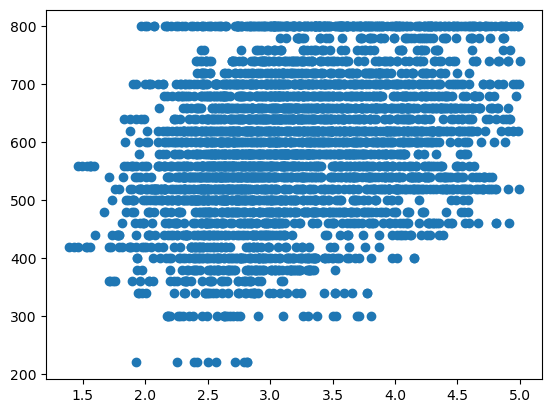

In [6]:
# Create a Scatter plot to compare the independent variables
plt.scatter(admissions['gpa'], admissions['gre'])

In [7]:
# Does it look like there is a correlation? 
admissions['gre'].corr(admissions['gpa'])

0.3199442653030231

array([[<AxesSubplot:title={'center':'admit'}>,
        <AxesSubplot:title={'center':'gre'}>],
       [<AxesSubplot:title={'center':'gpa'}>, <AxesSubplot:>]],
      dtype=object)

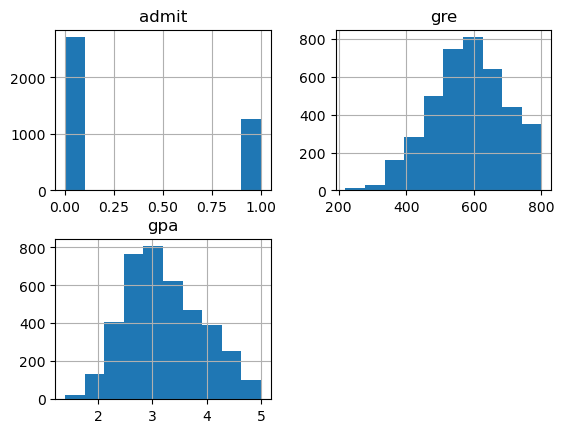

In [8]:
# Create a histogram to compare the distribution of the numeric variables
admissions.hist()

<AxesSubplot:xlabel='gre', ylabel='Count'>

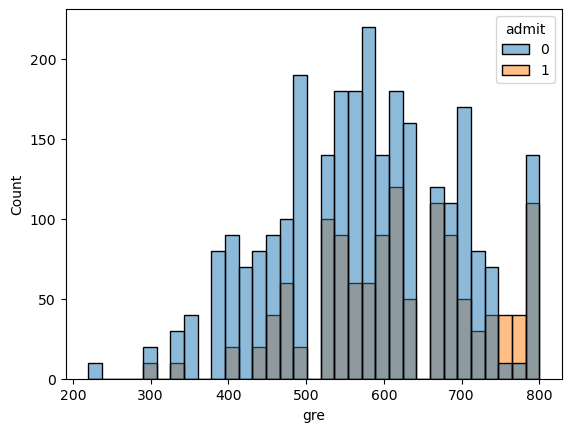

In [9]:
# Create a histogram to check distribution of gre by admit values
sns.histplot(admissions, x='gre',hue='admit')

<AxesSubplot:xlabel='gpa', ylabel='Count'>

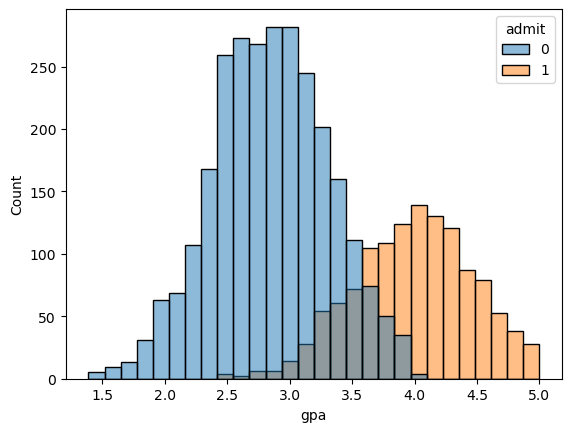

In [10]:
# Similarly create a histogram for gpa
sns.histplot(admissions, x='gpa',hue='admit')

There seems to be a clearer relationship between gpa and the value of admit. Let's try to perform the classification using Logistic Regression

## Recap of Notation

You're quite familiar with **linear** regression:

$$
\begin{eqnarray*}
\hat{\mathbf{y}} &=& \hat{\beta}_0 + \hat{\beta}_1x_1 + \hat{\beta}_2x_2 + \cdots + \hat{\beta}_px_p \\
&=& \hat{\beta}_0 + \sum_{j=1}^p\hat{\beta}_jX_j
\end{eqnarray*}
$$

Where:
- $\hat{\mathbf{y}}$ is the predicted values of $\mathbf{y}$ based on all of the inputs $x_j$.
- $x_1$, $x_2$, $\ldots$, $x_p$ are the predictors.
- $\hat{\beta}_0$ is the estimated intercept.
- $\hat{\beta}_j$ is the estimated coefficient for the predictor $x_j$, the $j$th column in variable matrix $X$.


<a id='plot-reg'></a>
### What if we predicted `admit` with `gpa` using Linear Regression?

Looking at the plot below, what are problems with using a regression?

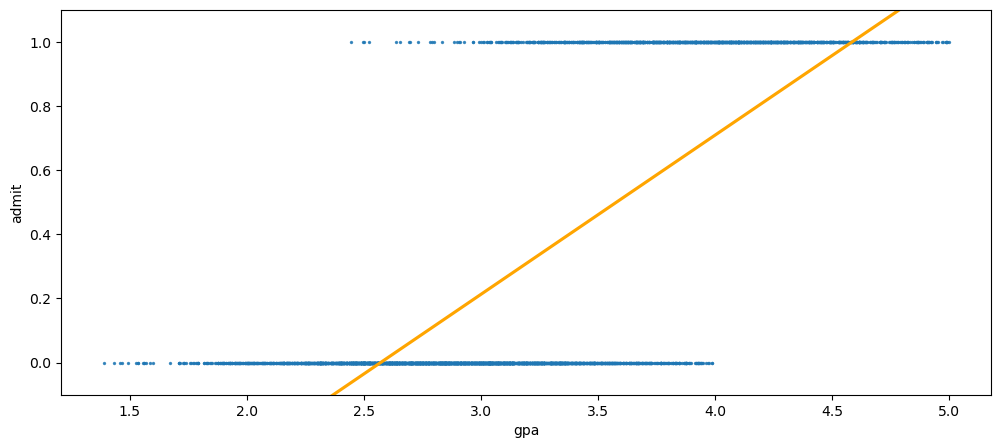

In [11]:
# plot admissions vs. gpa and line of best fit
plt.figure(figsize = (12, 5))
sns.regplot(x= admissions['gpa'], y= admissions['admit'], data= admissions,
            ci = False, scatter_kws = {'s': 2},
            line_kws = {'color': 'orange'})
plt.ylim(-0.1, 1.1);

<a id='pred-binary'></a>

## Predicting a Binary Class

---

In our case we have two classes: `1=admitted` and `0=rejected`.

The logistic regression is still solving for $\hat{y}$. However, in our binary classification case, $\hat{y}$ will be the probability of $y$ being one of the classes.

$$
\hat{y} = P(y = 1)
$$

We'll still try to fit a "line" of best fit to this... except it won't be perfectly linear. We need to *guarantee* that the right-hand side of the regression equation will evaluate to a probability. (That is, some number between 0 and 1!)

## Fitting and making predictions with the logistic regression model.

We can follow the same steps to build a logistic regression model that we follow to build a linear regression model.

1. Define X & y
2. Instantiate the model.
3. Fit the model.
4. Generate predictions.
5. Evaluate model.

In [13]:
admissions.head()

admit    gre       gpa
0      0  380.0  2.915018
1      1  660.0  4.044540
2      1  800.0  4.950714
3      1  640.0  3.921994
4      0  520.0  2.069878

In [14]:
# Step 1: Split into training & testing sets, using only 'gpa' as the independent variable and 'admit' as the target
X = admissions[['gpa']]
y = admissions['admit']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 50)

In [15]:
# Step 2: Instantiate our model.
logreg=LogisticRegression()
# Step 3: Fit our model.
logreg.fit(X_train, y_train)

# get the intercept and coefficient parameters
print(f'Logistic Regression Intercept : {logreg.intercept_}')
print(f'Logistic Regression Coefficient : {logreg.coef_}')
print(f'Logistic Regression Equation : logit(admit=1) = {logreg.intercept_[0]} + {logreg.coef_[0][0]}*GPA ' )

Logistic Regression Intercept : [-17.74407595]
Logistic Regression Coefficient : [[4.98338113]]
Logistic Regression Equation : logit(admit=1) = -17.744075947062218 + 4.983381127306725*GPA 


There are two methods in `sklearn` to be aware of when using logistic regression:
- `.predict()`
- `.predict_proba()`

In [16]:
# Step 4 (part 1): Generate predicted values on the test set
logreg.predict(X_test)

array([0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1,
       0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0,
       0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,

In [17]:
# Step 4 (part 2): Generate predicted probabilities on the test set
logreg.predict_proba(X_test)


array([[0.89882257, 0.10117743],
       [0.82481236, 0.17518764],
       [0.99512553, 0.00487447],
       ...,
       [0.99577129, 0.00422871],
       [0.97062176, 0.02937824],
       [0.01427957, 0.98572043]])

In [18]:
X_test.head()

gpa
1989  3.122351
3500  3.249757
123   2.493331
1368  3.707782
3301  3.469022

<details><summary>How would you interpret the predict_proba() output?</summary>
    
- This shows the probability of being rejected ($P(Y=0)$) and the probability of being admitted ($P(Y=1)$) for each observation in the testing dataset.
- The first array, corresponds to the first testing observation.
    - The `.predict()` value for this observation is 0. This is because $P(Y=0) > P(Y=1)$.
- The second array, corresponds to the second testing observation.
    - The `.predict()` value for this observation is 0. This is because $P(Y=0) > P(Y=1)$.
</details>

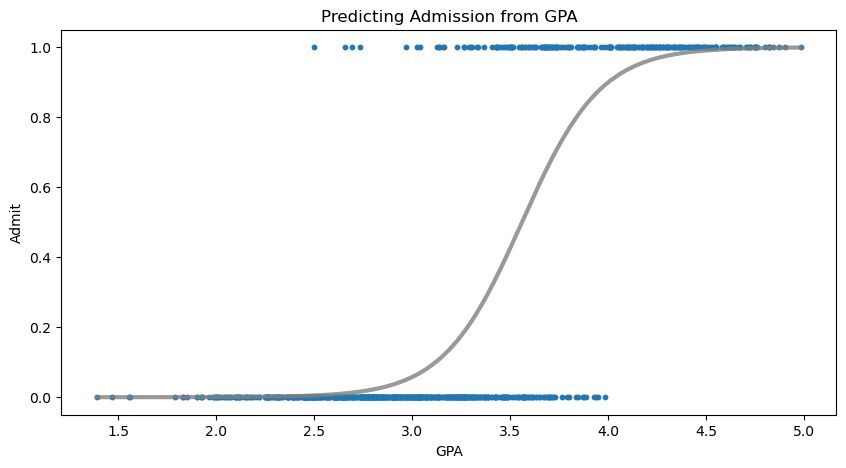

In [19]:
# Visualizing logistic regression probabilities.

plt.figure(figsize = (10, 5))

plt.scatter(X_test, y_test, s = 10);

plt.plot(X_test.sort_values('gpa'),
         logreg.predict_proba(X_test.sort_values('gpa'))[:,1],
         color = 'grey', alpha = 0.8, lw = 3)

plt.xlabel('GPA')
plt.ylabel('Admit')
plt.title('Predicting Admission from GPA');

In [20]:
# Step 5: Evaluate model using the score() method on the training data
logreg.score(X_train, y_train)

0.8967254408060453

In [21]:
# Step 6: Evaluate model using the score() method on the test data
logreg.score(X_test, y_test)


0.8979848866498741

By default, the `.score()` method for classification models gives us the accuracy score.

$$
\begin{eqnarray*}
\text{Accuracy} = \frac{\text{number of correct predictions}}{\text{number of total predictions}}
\end{eqnarray*}
$$

<details><summary>Remind me: what does .score() tell me for a regression model?</summary>
    
- The $R^2$ score.
- Remember that $R^2$ is the proportion of variance in our $Y$ values that are explained by our model.
</details>

### Using the log-odds —the natural logarithm of the odds.

The combination of converting the "probability of success" to "odds of success," then taking the logarithm of that is called the **logit link function**.

$$
\text{logit}\big(P(y=1)\big) = \log\bigg(\frac{P(y=1)}{1-P(y=1)}\bigg) = \beta_0 + \beta_1x_1 + \beta_2x_2 + \cdots + \beta_px_p
$$

We've bent our line how we want... but how do we interpret our coefficients?

### Odds

Probabilities and odds represent the same thing in different ways. The odds for probability **p** is defined as:

$$
\text{odds}(p) = \frac{p}{1-p}
$$

The odds of a probability is a measure of how many times as likely an event is to happen than it is to not happen.

**Example**: Suppose I'm looking at the probability and odds of a specific horse, "Secretariat," winning a race.

- When **`p = 0.5`**: **`odds = 1`**
    - The horse Secretariat is as likely to win as it is to lose.
- When **`p = 0.75`**: **`odds = 3`**
    - The horse Secretariat is three times as likely to win as it is to lose.
- When **`p = 0.40`**: **`odds = 0.666..`**
   - The horse Secretariat is two-thirds as likely to win as it is to lose.

## Interpreting a one-unit change in $x_i$.

$$\log\bigg(\frac{P(y=1)}{1-P(y=1)}\bigg) = \beta_0 + \beta_1x_1 + \beta_2x_2 + \cdots + \beta_px_p$$

Given this model, a one-unit change in $x_i$ implies a $\beta_i$ unit change in the log odds of success.

**This is annoying**.

We often convert log-odds back to "regular odds" when interpreting our coefficient... our mind understands odds better than the log of odds.

**(BONUS)** So, let's get rid of the log on the left-hand side. Mathematically, we do this by "exponentiating" each side.
$$
\begin{eqnarray*}
\log\bigg(\frac{P(y=1)}{1-P(y=1)}\bigg) &=& \beta_0 + \beta_1x_1 + \beta_2x_2 + \cdots + \beta_px_p \\
\Rightarrow e^{\Bigg(\log\bigg(\frac{P(y=1)}{1-P(y=1)}\bigg)\Bigg)} &=& e^{\Bigg(\beta_0 + \beta_1x_1 + \beta_2x_2 + \cdots + \beta_px_p\Bigg)} \\
\Rightarrow \frac{P(y=1)}{1-P(y=1)} &=& e^{\Bigg(\beta_0 + \beta_1x_1 + \beta_2x_2 + \cdots + \beta_px_p\Bigg)} \\
\end{eqnarray*}
$$

**Interpretation**: A one-unit change in $x_i$ means that success is $e^{\beta_i}$ times as likely.

In [22]:
logreg.coef_

array([[4.98338113]])

<details><summary> I want to interpret the coefficient $\hat{\beta}_1$ for my logistic regression model. How would I interpret this coefficient?</summary>
    
- Our model is that $\log\bigg(\frac{P(admit=1)}{1-P(admit=1)}\bigg) = \beta_0 + \beta_1\text{GPA}$.
- As GPA increases by 1, the log-odds of someone being admitted increases by 4.92.
- As GPA increases by 1, someone is $e^{4.92}$ times as likely to be admitted.
- As GPA increases by 1, someone is about 137.06 times as likely to be admitted to grad school.
</details>

> Hint: Use the [np.exp](https://docs.scipy.org/doc/numpy/reference/generated/numpy.exp.html) function.

In [23]:
# Use the np.exp function to calculate the odds
np.exp(logreg.coef_)

array([[145.96708153]])

## Saving the Model

Let's save the model in a pickle file to be used in the next notebook:


In [24]:
# Take the model logreg , and store it in file as a pickle format, .pkl
import pickle

filename = 'admissions_log_reg.pkl'
with open(filename, 'wb') as f:
    pickle.dump(logreg,f)

In [25]:
# Save the test sets too for evaluation later
X_test.to_csv('admissions_X_test.csv')
y_test.to_csv('admissions_y_test.csv')

## Summary


The goal of logistic regression is to find the best-fitting model to describe the relationship between a binary outcome and a set of independent variables.

Logistic regression generates the coefficients of a formula to predict a logit transformation of the probability that the characteristic of interest is present.

The coefficients are interpreted in terms of the odds of the event, where a one-unit change in the value of the independent variable with coefficient ${\beta}$ will increase the odds by $e^{\beta}$